In [5]:
%matplotlib inline

import pandas as pd
import numpy as np

from modelclass import model


In [7]:
fmodel      = '''
frml <> a = c(-1) + b $ 
frml <> d1 = x + 3 * e(-1)+ c **2 +a  $ 
frml <> d3 = x + 3 * a(-1)+c **3 $  
Frml <> x = 0.5 * c $'''
mmodel = model(fmodel,modelname = 'My first model')
df = pd.DataFrame({'B': [1,1,1,1],'C':[1,2,3,4],'E':[4,4,4,4]},index=[2018,2019,2020,2021])
base = mmodel(df)
base

Will start calculating: My first model
2019  solved
2020  solved
2021  solved
My first model calculated 


,B,C,E,D1,D3,A,X
2018,1.0,1.0,4.0,0.0,0.0,0.0,0.0
2019,1.0,2.0,4.0,19.0,9.0,2.0,1.0
2020,1.0,3.0,4.0,25.5,34.5,3.0,1.5
2021,1.0,4.0,4.0,34.0,75.0,4.0,2.0


In [122]:
from modelnewton import newton_diff
newton = newton_diff(mmodel)
newton2 = newton_diff(mmodel,forcenum=1)

In [123]:
print(newton.diff_model.equations)

FRML  <> D1__p__A___lag___0 = 1   $
FRML  <> D1__p__X___lag___0 = 1   $
FRML  <> D3__p__A___lag___1 = 3   $
FRML  <> D3__p__X___lag___0 = 1   $


In [124]:
print(newton2.diff_model.equations)

FRML  <> D1__p__A___lag___0 = ((X+3*E(-1)+C**2+(A+0.0025))-(X+3*E(-1)+C**2+(A-0.0025)))/0.005   $
FRML  <> D1__p__X___lag___0 = (((X+0.0025)+3*E(-1)+C**2+A)-((X-0.0025)+3*E(-1)+C**2+A))/0.005   $
FRML  <> D3__p__A___lag___1 = ((X+3*(A(-1)+0.0025)+C**3)-(X+3*(A(-1)-0.0025)+C**3))/0.005   $
FRML  <> D3__p__X___lag___0 = (((X+0.0025)+3*A(-1)+C**3)-((X-0.0025)+3*A(-1)+C**3))/0.005   $


In [125]:
stacked_df = newton.get_diff_df_tot()
stacked_df.applymap(lambda x:f'{x:,.2f}' if x != 0.0 else ' ')

per        2019                        2020                        2021  \
var           A     D1     D3      X      A     D1     D3      X      A   
per  var                                                                  
2019 A    -1.00                                                           
     D1    1.00  -1.00          1.00                                      
     D3                 -1.00   1.00                                      
     X                         -1.00                                      
2020 A                                -1.00                               
     D1                                1.00  -1.00          1.00          
     D3    3.00                                     -1.00   1.00          
     X                                                     -1.00          
2021 A                                                            -1.00   
     D1                                                            1.00   
     D3                                3.00                               
     X                                                                    

per                            
var          D1     D3      X  
per  var                       
2019 A                         
     D1                        
     D3                        
     X                         
2020 A                         
     D1                        
     D3                        
     X                         
2021 A                         
     D1   -1.00          1.00  
     D3          -1.00   1.00  
     X                  -1.00

In [173]:
def get_df(mul=0.9,acc=0.5,gdp=1000,im=200,years=100):
    'Creates imput dataframe to accelerator multiplier model '
    df = pd.DataFrame([[gdp]]*years,index=range(2018,2018+years),columns=['GDP'])
    df.loc[:,'MUL']= mul
    df.loc[:,'ACC']= acc
    df.loc[:,'CONSUMPTION']= gdp*mul
    df.loc[:,'EXO_INVESTMENT']= im
    return df
base = get_df()
base.head()

,GDP,MUL,ACC,CONSUMPTION,EXO_INVESTMENT
2018,1000,0.9,0.5,900.0,200
2019,1000,0.9,0.5,900.0,200
2020,1000,0.9,0.5,900.0,200
2021,1000,0.9,0.5,900.0,200
2022,1000,0.9,0.5,900.0,200


In [193]:
from modelmanipulation import find_hist_model
from modelnewton import newton_diff

fam   = f'''
frml <>  gdp = consumption+investment $ 
frml <I> consumption = mul * gdp(-1) $
frml <>  investment = acc * (consumption-consumption(-1)) + exo_investment $'''
mma_base = model(fam,modelname = 'Accelerator multiplicator model')

In [196]:
def geteigen(mul,acc,years=100,show=False):
    from copy import copy 
    '''Function which creates a Samuelson Multiplier accelerator model, runs it and 
    calculates the eigenvalues for the compaignion matrix in order to evaluate stability'''
    first = get_df(mul,acc,years=years)
    mma = copy(mma_base)
    base  = mma(first,silent=True)     # Solve the model 
    mma_newton = newton_diff(mma) 
    eig_dic = mma_newton.get_eigenvectors()
    mma_newton.eigplot(eig_dic);

    if show:
        _ = mma['gdp consumption investment'].plot(top=0.8,title='Values',colrow=3)  # Show the solution
    return  mma_newton

Stability   

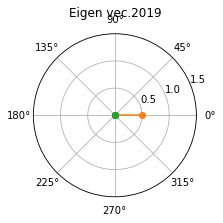

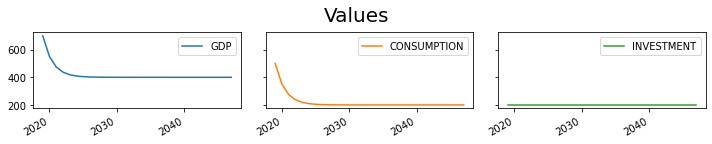

In [222]:
geteigen(mul=0.5,acc=0,years=30,show=1);

Explosion 

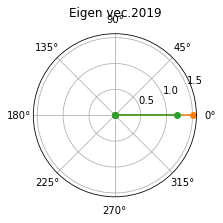

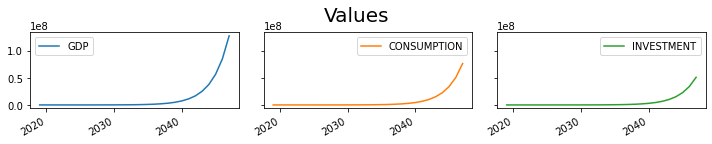

In [215]:
exp = geteigen(mul=0.9,acc=2,years=30,show=1);

Exploding oscillations

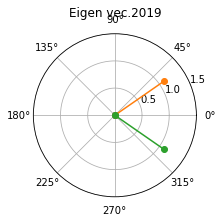

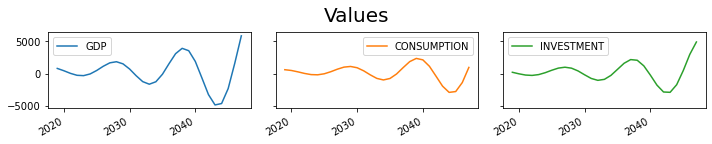

In [199]:
geteigen(mul=0.6,acc=2,years=30,show=1);

Perpetual oscillations 

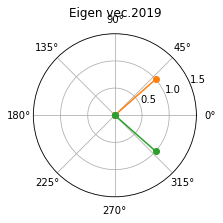

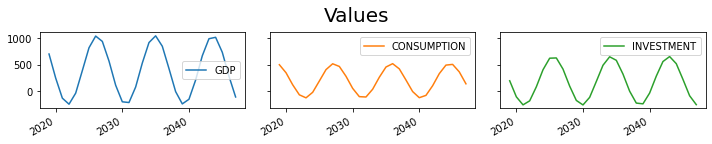

In [219]:
geteigen(mul=0.5,acc=2,years=30,show=1)

Dampened oscillations 

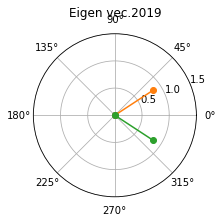

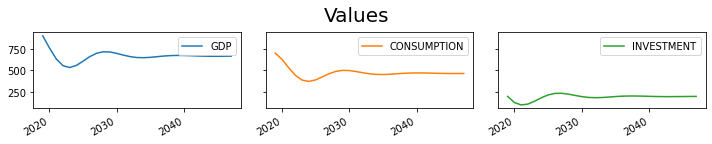

In [203]:
damp = geteigen(mul=0.7,acc=1,years=30,show=1);

In [211]:
max(damp.get_eigenvectors(2019)[2019])

(0.7000000000000001+0.4582575694955842j)

In [212]:
max(abs(damp.get_eigenvectors(2019)[2019]))

0.8366600265340757

In [213]:
damp.get_eigenvectors(2019)[2019].real

array([0. , 0.7, 0.7])

In [221]:
damp.get_eigenvectors(2019)[2019].imag

array([ 0.        ,  0.45825757, -0.45825757])

In [212]:
max(abs(damp.get_eigenvectors(2019)[2019]))

0.8366600265340757